In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import fabio, sys, h5py

sys.path.insert(0, '../scripts/')
from integrators import*
from utilities import *
from files_tools import*


In [2]:
save = False

In [3]:
# save teh path of the working directory
%cd ..
path = !pwd
path = path[0]
path

/Users/maddalena/Nextcloud/01-SU/beamtimes/22-09-P10-LLT/02-tests/01-xrd


'/Users/maddalena/Nextcloud/01-SU/beamtimes/22-09-P10-LLT/02-tests/01-xrd'

## Load data

In [13]:
# import calibrated Qs
q = np.load('./source/q.npy')
mask = np.load('./source/mask.npy')
x,y = np.load('./source/centers.npy')

In [12]:
Ih_ref = np.array([1.61297476, 1.71327851, 1.8264895 , 2.35318655, 2.79464445,
       3.03451657, 3.22634856, 3.27789344, 3.33837302, 3.6533046 ])

In [198]:
def D2O_ice_peaks():
    '''
    returns the D2O ice Ih (hexagonal) peak positions (in Angst-1) 
    '''
    ice_2theta = np.array([18.8632,21.4028,23.6378,27.7182,33.0320,36.0129,38.3421,43.6751,46.2558])
    xrd_energy = 8.05 #keV at Cu K-alpha (using a copper anode)
    h = 4.135667516*1e-18 #kev*sec
    c = 3*1e8 #m/s
    lambda_ = h*c/xrd_energy*1e10 #1.5498 Angst # wavelength of the X-rays

    # -- convert degrees to theta
    ice_q = 4.*np.pi*np.sin(ice_2theta/2.*np.pi/180.)/lambda_

    return ice_q

D2O_ref = D2O_ice_peaks()

# Angular average

In [14]:
!ls data/

AgBeh_01.sfrm       EmptyKapton_01.sfrm


In [15]:
# background 
bg_fn = 'data/EmptyKapton_01.sfrm'
im_bg = fabio.open(bg_fn)
bg_ar = np.array(im_bg.data,dtype=float)

Parameters 

In [17]:
# -- angular integration parameters
n_bins = len(q)    # number of bins
mask_thr = 0    # threshold limit for integrator

p_size = 96e-6        # size of the pixels
d = 50e-3              # detector distance
Cu_energy = 8041.       # energy of the beam (Cu K\alpha)

Background angular average

In [18]:
# r-map
rad_dist = radial_distances(bg_ar, center=(int(y),int(x)))

# angular average
# bg_ar is a 2d array (the image)
r_bg,iq_bg = angular_average(bg_ar,mask=mask,rad=rad_dist,threshold=mask_thr,nx=n_bins)

# Angular averages of all samples

**Function**

In [19]:
def ang_and_plot(filename):
    img = fabio.open(filename) # bruker type
    img2d = np.array(img.data,dtype=float) # array type
    r, Iq = angular_average(img2d, mask=mask, rad=rad_dist,threshold=mask_thr,nx=n_bins)
    return Iq

In [20]:
!ls data/

AgBeh_01.sfrm       EmptyKapton_01.sfrm


**Compute the angular average for some samples**

In [23]:
# background
Iq_bg = ang_and_plot('data/EmptyKapton_01.sfrm')

In [24]:
# function to subtract the background
def subtr_offset(Iq, Iq_bg, w=1.):
    off = Iq_bg[0] - Iq[0]
    Iq_npbg = Iq - w*(Iq_bg-off)
    
    return Iq_npbg

# Loop over all files

In [25]:
# if you want to save all filenames in a list and then loop over it
files =!ls data
print(path+'/data/%s' %files[-1])

/Users/maddalena/Nextcloud/01-SU/beamtimes/22-09-P10-LLT/02-tests/01-xrd/data/EmptyKapton_01.sfrm


In [26]:
for i in range(len(files)):
    print(i, files[i])

0 AgBeh_01.sfrm
1 EmptyKapton_01.sfrm


In [27]:
# save all Iq in one array: with and without bg
Iq_all = np.empty(shape=(len(files), n_bins))
Iq_all_nobg = np.empty(shape=(len(files), n_bins))

for i in range(len(files)):
    Iq_all[i] = ang_and_plot(path+'/data/%s' %files[i])
    if i == 1:
        Iq_all_nobg[i] = Iq_bg
    if i != 1:
        Iq_all_nobg[i] = subtr_offset(Iq_all[i], Iq_bg, w=.9)

In [256]:
# A3641 concentrated
A3641_c = Iq_all_nobg[2:8,:]
F4503_c = Iq_all_nobg[8:16,:]
powder = Iq_all_nobg[17:,:]

In [257]:
F4503_c.shape

(8, 512)

## All measurements

IndexError: list index out of range

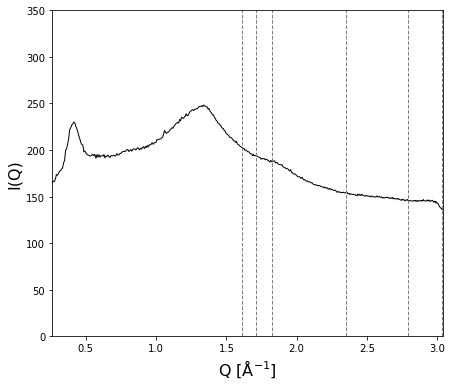

In [29]:
# plot files
plt.figure(figsize=(7,6))
col = plt.cm.coolwarm_r(np.linspace(0,1,3))

# A3641 conc
plt.plot(q, Iq_all[1,:], c='k', lw=1, label=f'{files[1][:-5]}')
##for i in range(len(A3641_c)-1):
#    plt.plot(q, A3641_c[i,:], c=col[i], lw=1, label=f'{files[i+2][-8:-5]}')
#plt.plot(q, 0.2*A3641_c[-1,:], c=col[-1], lw=1, label=f'{files[i+2][:-5]} \n(rescaled)')
    #plt.plot(q, A3641_c[i,:]/np.max(A3641_c[i,:]), c=col[i], lw=1, label=f'{files[i+2][:-5]}')

for ice in Ih_ref: plt.axvline(x=ice, ls='--', lw=1, c='gray')
#plt.axvline(x=.65)
plt.xlabel(r'Q [$\rm\AA^{-1}$]', fontsize=16)
plt.ylabel(r'I(Q)', fontsize=16)
plt.xlim(q[0], q[-1])
plt.ylim(0, 350)
plt.title(files[3][3:8], fontsize=16)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
#plt.savefig('/Users/maddalena/Desktop/apof.png', dpi=300)
plt.show()

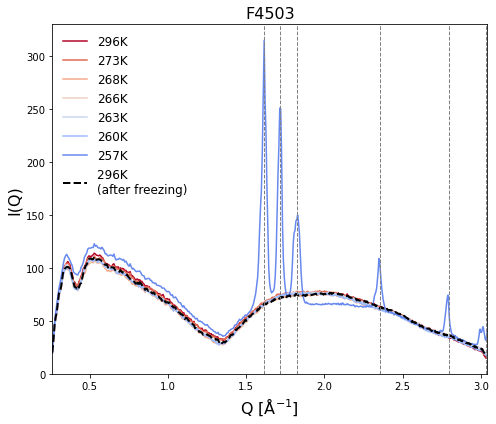

In [284]:
# plot files
plt.figure(figsize=(7,6))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(F4503_c)))

#plt.plot(q, Iq_all[1,:]-75, c='k', lw=1, label=f'{files[1][:-5]}')
# F4503 conc
for i in range(len(F4503_c)-1):
    #plt.plot(q, F4503_c[i,:]/np.max(F4503_c[i,:]), c=col[i], lw=1, label=f'{files[i+2][:-5]}')
    plt.plot(q, F4503_c[i,:], c=col[i], lw=1.5, label=f'{files[i+8][-8:-5]}K')
plt.plot(q, F4503_c[-1,:], c='k', lw=2, ls='--', label=f'{files[15][-8:-5]}K \n(after freezing)')

for ice in Ih_ref: plt.axvline(x=ice, ls='--', lw=1, c='gray')
#plt.axvline(x=.65)
plt.xlabel(r'Q [$\rm\AA^{-1}$]', fontsize=16)
plt.ylabel(r'I(Q)', fontsize=16)
plt.xlim(q[0], q[-1])
plt.legend(frameon=False, fontsize=12)
plt.title(files[8][3:8], fontsize=16)
plt.tight_layout()
plt.savefig('/Users/maddalena/Desktop/ferr.png', dpi=300)
plt.show()

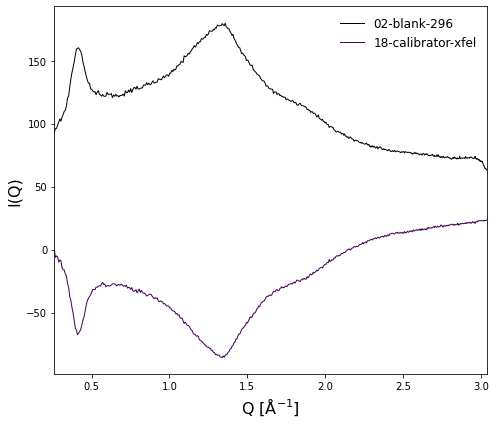

In [243]:
# plot files
plt.figure(figsize=(7,6))
col = plt.cm.viridis(np.linspace(0,1,len(powder)))

plt.plot(q, Iq_all[1,:]-75, c='k', lw=1, label=f'{files[1][:-5]}')
# F4503 conc
for i in range(len(powder)):
    #plt.plot(q, powder[i,:]/np.max(powder[i,:]), c=col[i], lw=1, label=f'{files[i+2][:-5]}')
    plt.plot(q, powder[i,:], c=col[i], lw=1, label=f'{files[i+17][:-5]}')

#for ice in Ih_ref: plt.axvline(x=ice, ls='--', lw=1, c='gray')
#plt.axvline(x=.65)
plt.xlabel(r'Q [$\rm\AA^{-1}$]', fontsize=16)
plt.ylabel(r'I(Q)', fontsize=16)
plt.xlim(q[0], q[-1])
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

# Save raw in h5 file

In [ ]:
!pwd

In [ ]:
if save == True:
    f = h5py.File('source/2021-03-16-all.hdf5', 'w') # w stads for write

    g1 = f.create_group('tool')
    g1.create_dataset('calibrator', data=Iq_all[0])
    g1.create_dataset('background', data=Iq_all[1])
    
    #g2 = f.create_group('Iq')
    #g2.create_dataset('Lys200_vol', data=Iq_all[7:15])
    #g2.create_dataset('Lys200_wei', data=Iq_all[22:27])
    #g2.create_dataset('Wat-Gly_11v', data=Iq_all[2:7])
    
    f.visititems(visit_func)   
    f.close()

In [ ]:
f = h5py.File('source/2021-03-16-all.hdf5', 'r')
f.visititems(visit_func)   
f.close()


In [ ]:
!ls source